# OWASP Benchmark SAST Tool Analysis
## Scorecard Metrics Extraction and Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import glob
import os
import json
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Data Extraction Functions

In [2]:
tool_types = {'CodeQL':'SAST', 'Semgrep':'SAST', 'SonarQube':'SAST', 'PMD':'SAST',
              'Qwiet': 'ML', 'SnykCode': 'ML',
              'Corgea': 'AI', 'Qodo': 'AI', 'Endor': 'AI'}

In [3]:
def parse_tool_scorecard(html_file):
    """
    Parse individual tool scorecard HTML to extract metrics.
    Returns DataFrame with vulnerability-specific metrics for the tool.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract tool name from title or heading
    title = soup.find('h3')
    if title:
        tool_name = title.text.replace('OWASP Benchmark Scorecard for ', '').replace(' (SAST)', '').strip()
    else:
        tool_name = Path(html_file).stem
    
    # find results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        # check if this is the detailed results table
        if 'Category' in headers and 'CWE #' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]: # skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9: # ensure data
                    if cells[0] not in ['Totals', 'Overall Results*']:
                        rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Category', 'CWE', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Tool'] = tool_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                #convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_vulnerability_scorecard(html_file):
    """
    Parse vulnerability-specific scorecard to extract all tools' performance on that vulnerability.
    """

    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # extract vulnerability name
    title = soup.find('h3')
    if title:
        vuln_name = title.text.replace('OWASP Benchmark Scorecard for ', '').strip()
    else:
        vuln_name = Path(html_file).stem
    
    # find the detailed results table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]: # skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 9:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TP', 'FN', 'TN', 'FP', 'Total', 'TPR', 'FPR', 'Score'])
                df['Vulnerability'] = vuln_name
                
                # convert numeric columns
                numeric_cols = ['TP', 'FN', 'TN', 'FP', 'Total']
                for col in numeric_cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # convert percentage columns
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

def parse_summary_scorecard(html_file):
    """
    Parse the summary scorecard to get overall tool scores.
    """
    
    with open(html_file, 'r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read(), 'html.parser')
    
    # find summary table
    tables = soup.find_all('table', class_='table')
    
    for table in tables:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        if 'Tool' in headers and 'Type' in headers and 'Score*' in headers:
            rows = []
            for tr in table.find_all('tr')[1:]:  # Skip header
                cells = [td.text.strip() for td in tr.find_all('td')]
                if cells and len(cells) >= 4:
                    rows.append(cells)
            
            if rows:
                df = pd.DataFrame(rows, columns=['Tool', 'Type', 'TPR', 'FPR', 'Score'])
                
                for col in ['TPR', 'FPR', 'Score']:
                    df[col] = df[col].str.rstrip('%').astype('float')
                
                return df
    
    return None

## Load All Scorecard Data

In [4]:
scorecard_dir = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard'
to_save = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/BenchmarkJava/scorecard/outputs/'
os.makedirs(to_save, exist_ok=True)

In [5]:
# find all scorecard HTML files
tool_scorecards = glob.glob(os.path.join(scorecard_dir, '*CodeQL*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Semgrep*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Snyk*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SonarQube*.html'))

vuln_scorecards = glob.glob(os.path.join(scorecard_dir, '*Command_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*SQL_Injection*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XSS*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Path_Traversal*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*LDAP*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Weak_*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Insecure_Cookie*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*Trust_Boundary*.html')) + \
                  glob.glob(os.path.join(scorecard_dir, '*XPath*.html'))

summary_file = os.path.join(scorecard_dir, 'Scorecard_Home.html')

print(f"Found {len(tool_scorecards)} tool-specific scorecards")
print(f"Found {len(vuln_scorecards)} vulnerability-specific scorecards")
print(f"Summary file exists: {os.path.exists(summary_file)}")

Found 4 tool-specific scorecards
Found 11 vulnerability-specific scorecards
Summary file exists: True


In [6]:
# parse all tool scorecards
tool_data = []
for file in tool_scorecards:
    df = parse_tool_scorecard(file)
    if df is not None:
        tool_data.append(df)

if tool_data:
    df_tools = pd.concat(tool_data, ignore_index=True)
    print(f"Loaded data for {df_tools['Tool'].nunique()} tools across {df_tools['Category'].nunique()} vulnerability categories")
    print(f"Total records: {len(df_tools)}")
else:
    print("No tool data loaded")

Loaded data for 4 tools across 11 vulnerability categories
Total records: 44


In [7]:
# parse all vulnerability scorecards
vuln_data = []
for file in vuln_scorecards:
    df = parse_vulnerability_scorecard(file)
    if df is not None:
        vuln_data.append(df)

if vuln_data:
    df_vulns = pd.concat(vuln_data, ignore_index=True)
    print(f"Loaded vulnerability data for {df_vulns['Vulnerability'].nunique()} vulnerabilities")
else:
    print("No vulnerability data loaded")

Loaded vulnerability data for 11 vulnerabilities


In [8]:
# parse summary
if os.path.exists(summary_file):
    df_summary = parse_summary_scorecard(summary_file)
    if df_summary is not None:
        print(f"Loaded summary data for {len(df_summary)} tools")
        display(df_summary)
else:
    print("Summary file not found")

Loaded summary data for 4 tools


,Tool,Type,TPR,FPR,Score
0,CodeQL v2.23.6_w1.10.0rules,SAST,100.00,37.99,62.01
1,Semgrep v1.143.1,SAST,82.58,47.48,35.10
2,SnykCode v1.1301.0,SAST,97.18,25.16,72.02
3,SonarQube,SAST,9.09,2.12,6.97


## Load Results from Other Tools

In [9]:
def load_framework_results(json_file, tool_name):
    """
    Load analysis results from our framework's JSON format and convert to scorecard format.
    """
    
    # Category mapping from abbreviated names to full scorecard names
    category_map = {
        'cmdi': ('Command Injection', '78'),
        'crypto': ('Weak Encryption Algorithm', '327'),
        'hash': ('Weak Hashing Algorithm', '328'),
        'ldapi': ('LDAP Injection', '90'),
        'pathtraver': ('Path Traversal', '22'),
        'securecookie': ('Insecure Cookie', '614'),
        'sqli': ('SQL Injection', '89'),
        'trustbound': ('Trust Boundary', '501'),
        'weakrand': ('Weak Randomness', '330'),
        'xpathi': ('XPath Injection', '643'),
        'xss': ('XSS (Cross-Site Scripting)', '79')
    }
    
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    rows = []
    
    for short_name, metrics in data['by_category'].items():
        if short_name not in category_map:
            continue

        category_name, cwe = category_map[short_name]

        # Extract metrics
        total = metrics['total_tests']
        expected = metrics['vulnerable_tests']
        non_category_cases = metrics['safe_tests']
        tp = metrics['tp']
        fp = metrics['fp']
        fn = metrics['fn']
        tn = metrics['tn']

        # Calculate rates
        tpr = (tp / expected * 100) if expected > 0 else 0.0
        fpr = (fp / non_category_cases * 100) if non_category_cases > 0 else 0.0
        score = tpr - fpr

        rows.append({
            'Category': category_name,
            'CWE': cwe,
            'TP': tp,
            'FN': fn,
            'TN': tn,
            'FP': fp,
            'Total': total,
            'TPR': round(tpr, 2),
            'FPR': round(fpr, 2),
            'Score': round(score, 2),
            'Tool': tool_name
        })

    return pd.DataFrame(rows)

In [10]:
qwiet_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/qwiet_analysis.json'
corgea_file = '/Users/ibrahimmalik/Documents/code_tests/code-analysis/tool_analysis/reports/corgea_analysis.json'

In [11]:
additional_tools = []

In [12]:
# Load Qwiet
if os.path.exists(qwiet_file):
    df_qwiet = load_framework_results(qwiet_file, 'Qwiet')
    additional_tools.append(df_qwiet)
    print(f"Loaded Qwiet data: {len(df_qwiet)} vulnerability categories")
else:
    print(f"Qwiet file not found: {qwiet_file}")

Loaded Qwiet data: 4 vulnerability categories


In [13]:
# Load Corgea
if os.path.exists(corgea_file):
    df_corgea = load_framework_results(corgea_file, 'Corgea')
    additional_tools.append(df_corgea)
    print(f"Loaded Corgea data: {len(df_corgea)} vulnerability categories")
else:
    print(f"Corgea file not found: {corgea_file}")

Loaded Corgea data: 11 vulnerability categories


In [14]:
# Merge with existing tool data
if additional_tools and 'df_tools' in locals():
    df_tools_original = df_tools.copy()
    df_tools = pd.concat([df_tools_original] + additional_tools, ignore_index=True)
    df_tools['Tool'] = df_tools['Tool'].apply(lambda x: x.split()[0] if ' ' in x else x)
    df_tools['Type'] = df_tools['Tool'].apply(lambda tool: tool_types.get(tool, 'Unknown'))
    
    print(f"Combined dataset now includes {df_tools['Tool'].nunique()} tools")
    print(f"Tools: {', '.join(df_tools['Tool'].unique())}")
elif additional_tools:
    df_tools = pd.concat(additional_tools, ignore_index=True)
    print(f"Created dataset with {df_tools['Tool'].nunique()} tools from framework")

Combined dataset now includes 6 tools
Tools: CodeQL, Semgrep, SnykCode, SonarQube, Qwiet, Corgea


In [15]:
# Calculate overall metrics for all tools
tool_summary = []

for tool in df_tools['Tool'].unique():
    tool_data = df_tools[df_tools['Tool'] == tool]
    
    # Calculate weighted averages
    total_expected = tool_data['Total'].sum()
    total_tp = tool_data['TP'].sum()
    total_fp = tool_data['FP'].sum()
    total_fn = tool_data['FN'].sum()
    total_tn = tool_data['TN'].sum()
    
    total_vulnerable = total_tp + total_fn
    total_non_vulnerable = total_tn + total_fp

    # Calculate overall TPR and FPR
    overall_tpr = (total_tp / total_vulnerable * 100) if total_vulnerable > 0 else 0
    overall_fpr = (total_fp / total_non_vulnerable * 100) if total_non_vulnerable > 0 else 0
    
    overall_score = overall_tpr - overall_fpr

    tool_summary.append({
        'Tool': tool,
        'Type': tool_types.get(tool, 'Unknown'),
        'TPR': round(overall_tpr, 2),
        'FPR': round(overall_fpr, 2),
        'Score': round(overall_score, 2)
    })

# Create updated summary
df_summary = pd.DataFrame(tool_summary)
display(df_summary.sort_values('Score', ascending=False))

,Tool,Type,TPR,FPR,Score
2,SnykCode,ML,97.17,21.89,75.29
0,CodeQL,SAST,100.00,40.08,59.92
4,Qwiet,ML,96.60,42.53,54.07
1,Semgrep,SAST,74.42,41.66,32.76
5,Corgea,AI,37.64,29.38,8.25
3,SonarQube,SAST,9.19,2.04,7.15


## Data Overview and Statistics

In [16]:
print("### Tool-Specific Data Overview ###")
display(df_tools.head(15))

print("\nTools analyzed:")
print(df_tools['Tool'].unique())

print("\nVulnerability categories:")
print(df_tools['Category'].unique())

### Tool-Specific Data Overview ###


,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool,Type
0,Command Injection,78,126,0,61,64,251,100.00,51.20,48.80,CodeQL,SAST
1,Insecure Cookie,614,36,0,31,0,67,100.00,0.00,100.00,CodeQL,SAST
2,LDAP Injection,90,27,0,19,13,59,100.00,40.62,59.38,CodeQL,SAST
3,Path Traversal,22,133,0,69,66,268,100.00,48.89,51.11,CodeQL,SAST
4,SQL Injection,89,272,0,25,207,504,100.00,89.22,10.78,CodeQL,SAST
5,Trust Boundary,501,83,0,19,24,126,100.00,55.81,44.19,CodeQL,SAST
6,Weak Encryption Algorithm,327,130,0,89,27,246,100.00,23.28,76.72,CodeQL,SAST
7,Weak Hashing Algorithm,328,129,0,74,33,236,100.00,30.84,69.16,CodeQL,SAST
8,Weak Randomness,330,218,0,275,0,493,100.00,0.00,100.00,CodeQL,SAST
9,XPath Injection,643,15,0,13,7,35,100.00,35.00,65.00,CodeQL,SAST



Tools analyzed:
['CodeQL' 'Semgrep' 'SnykCode' 'SonarQube' 'Qwiet' 'Corgea']

Vulnerability categories:
['Command Injection' 'Insecure Cookie' 'LDAP Injection' 'Path Traversal'
 'SQL Injection' 'Trust Boundary' 'Weak Encryption Algorithm'
 'Weak Hashing Algorithm' 'Weak Randomness' 'XPath Injection'
 'XSS (Cross-Site Scripting)']


In [17]:
df_tools[df_tools['Tool']=='Corgea']

,Category,CWE,TP,FN,TN,FP,Total,TPR,FPR,Score,Tool,Type
48,Command Injection,78,78,89,50,34,251,46.71,40.48,6.23,Corgea,AI
49,Weak Encryption Algorithm,327,39,113,71,23,246,25.66,24.47,1.19,Corgea,AI
50,Weak Hashing Algorithm,328,0,156,80,0,236,0.00,0.00,0.00,Corgea,AI
51,LDAP Injection,90,24,18,9,8,59,57.14,47.06,10.08,Corgea,AI
52,Path Traversal,22,91,86,52,39,268,51.41,42.86,8.56,Corgea,AI
53,Insecure Cookie,614,16,29,16,6,67,35.56,27.27,8.28,Corgea,AI
54,SQL Injection,89,220,134,64,86,504,62.15,57.33,4.81,Corgea,AI
55,Trust Boundary,501,4,77,36,9,126,4.94,20.00,-15.06,Corgea,AI
56,Weak Randomness,330,9,304,179,1,493,2.88,0.56,2.32,Corgea,AI
57,XPath Injection,643,9,16,3,7,35,36.00,70.00,-34.00,Corgea,AI


In [18]:
print("Statistical Summary by Tool")

summary_stats = df_tools.groupby(['Tool', 'Type']).agg({
    'TPR': ['mean', 'std', 'min', 'max'],
    'FPR': ['mean', 'std', 'min', 'max'],
    'Score': ['mean', 'std', 'min', 'max'],
    'TP': 'sum',
    'FP': 'sum',
    'FN': 'sum',
    'TN': 'sum'
}).round(2)

summary_stats['Total'] = summary_stats['TP']['sum'] + summary_stats['FN']['sum'] + summary_stats['TN']['sum'] + summary_stats['FP']['sum']

display(summary_stats)

Statistical Summary by Tool


TPR                           FPR                      \
                  mean    std     min     max   mean    std  min     max   
Tool      Type                                                             
CodeQL    SAST  100.00   0.00  100.00  100.00  37.99  25.36  0.0   89.22   
Corgea    AI     34.53  23.20    0.00   62.15  35.05  22.78  0.0   70.00   
Qwiet     ML     98.59   2.83   94.35  100.00  75.00  50.00  0.0  100.00   
Semgrep   SAST   82.58  28.93    0.00  100.00  47.48  38.85  0.0   87.50   
SnykCode  ML     97.18   9.35   68.99  100.00  25.16  21.55  0.0   55.81   
SonarQube SAST    9.09  30.15    0.00  100.00   2.12   7.02  0.0   23.28   

                Score                          TP   FP    FN    TN Total  
                 mean    std    min     max   sum  sum   sum   sum        
Tool      Type                                                            
CodeQL    SAST  62.01  25.36  10.78  100.00  1415  531     0   794  2740  
Corgea    AI    -0.53  13.02 -34.00   10.08   720  243  1193   584  2740  
Qwiet     ML    23.59  47.18   0.00   94.35   568  111    20   150   849  
Semgrep   SAST  35.10  36.74   0.00  100.00  1053  552   362   773  2740  
SnykCode  ML    72.02  19.90  44.19  100.00  1375  290    40  1035  2740  
SonarQube SAST   6.97  23.13   0.00   76.72   130   27  1285  1298  2740

## Overall Performance Comparison

In [19]:
type_to_color = {
                'SAST': 'skyblue',
                'ML': 'salmon',
                'AI': 'lightgreen'
            }

type_to_cmap = {
                'SAST': 'Blues',
                'ML': 'Reds',
                'AI': 'Greens'
            }

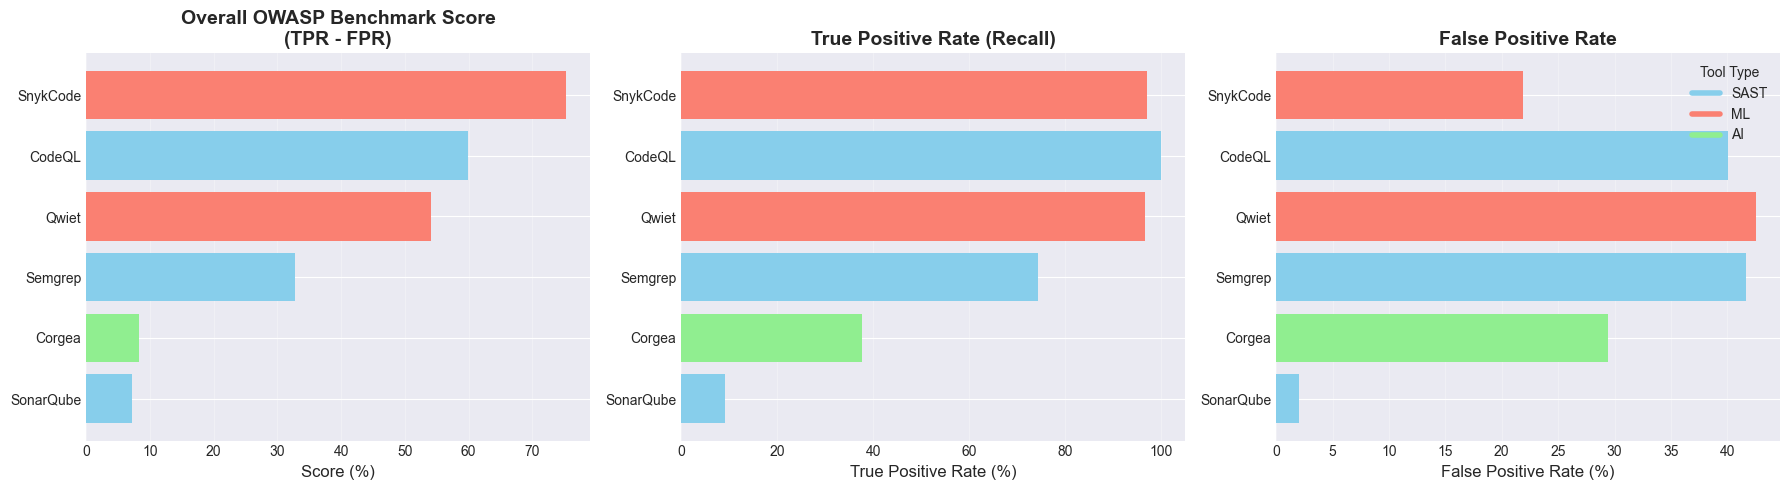

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# overall scores
df_summary_sorted = df_summary.sort_values('Score', ascending=True)
axes[0].barh(df_summary_sorted['Tool'], df_summary_sorted['Score'], color=df_summary_sorted['Type'].map(type_to_color))
axes[0].set_xlabel('Score (%)', fontsize=12)
axes[0].set_title('Overall OWASP Benchmark Score\n(TPR - FPR)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# TPR comparison
axes[1].barh(df_summary_sorted['Tool'], df_summary_sorted['TPR'], color=df_summary_sorted['Type'].map(type_to_color))
axes[1].set_xlabel('True Positive Rate (%)', fontsize=12)
axes[1].set_title('True Positive Rate (Recall)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# FPR comparison
axes[2].barh(df_summary_sorted['Tool'], df_summary_sorted['FPR'], color=df_summary_sorted['Type'].map(type_to_color))
axes[2].set_xlabel('False Positive Rate (%)', fontsize=12)
axes[2].set_title('False Positive Rate', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.legend(handles=[
    plt.Line2D([0], [0], color='skyblue', lw=4, label='SAST'),
    plt.Line2D([0], [0], color='salmon', lw=4, label='ML'),
    plt.Line2D([0], [0], color='lightgreen', lw=4, label='AI')
], title='Tool Type', loc='upper right')

plt.tight_layout()
plt.show()

## Performance Heatmap by Vulnerability Type

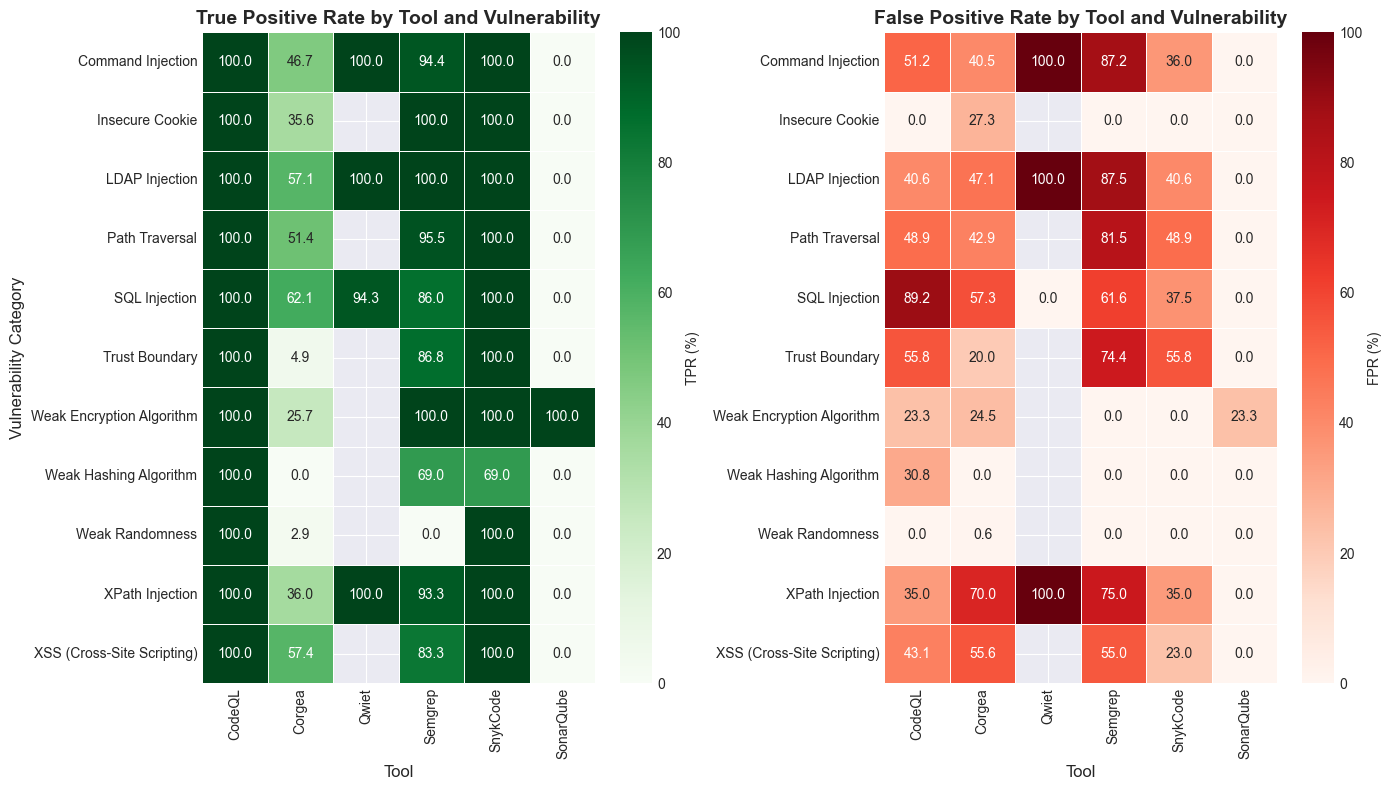

In [21]:
# pivot tables for heatmaps
pivot_tpr = df_tools.pivot(index='Category', columns='Tool', values='TPR')
pivot_fpr = df_tools.pivot(index='Category', columns='Tool', values='FPR')

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# TPR Heatmap
sns.heatmap(pivot_tpr, annot=True, fmt='.1f', cmap='Greens', ax=axes[0], 
            cbar_kws={'label': 'TPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
axes[0].set_title('True Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tool', fontsize=12)
axes[0].set_ylabel('Vulnerability Category', fontsize=12)

# FPR Heatmap
sns.heatmap(pivot_fpr, annot=True, fmt='.1f', cmap='Reds', ax=axes[1], 
            cbar_kws={'label': 'FPR (%)'}, linewidths=0.5, vmin=0, vmax=100)
axes[1].set_title('False Positive Rate by Tool and Vulnerability', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tool', fontsize=12)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## Score Heatmap

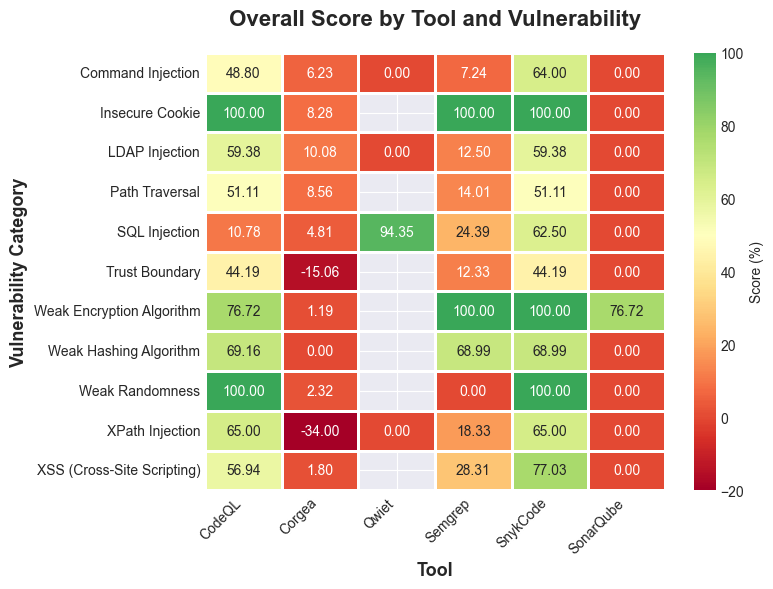

In [22]:
pivot_score = df_tools.pivot(index='Category', columns='Tool', values='Score')

plt.figure(figsize=(8, 6))

sns.heatmap(pivot_score, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score (%)'},
            linewidths=1, linecolor='white',
            center=50, vmin=-20, vmax=100)

plt.title('Overall Score by Tool and Vulnerability', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tool', fontsize=13, fontweight='bold')
plt.ylabel('Vulnerability Category', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Performance by Vulnerability Type

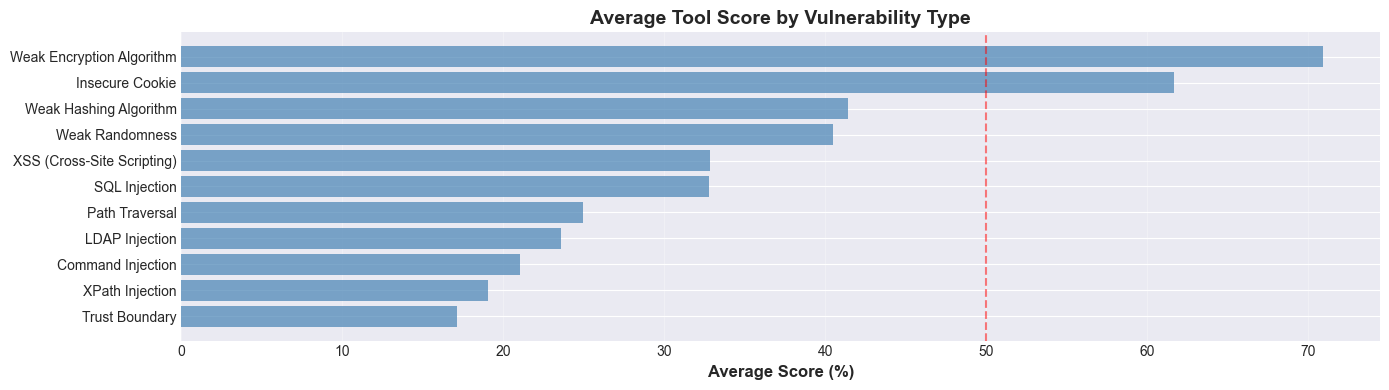

In [23]:
# calculate average performance per vulnerability
vuln_avg = df_tools.groupby('Category')[['TPR', 'FPR', 'Score']].mean().sort_values('Score', ascending=True)

fig, axes = plt.subplots(1, 1, figsize=(14,4))

# score by vulnerability
axes.barh(vuln_avg.index, vuln_avg['Score'], color='steelblue', alpha=0.7)
axes.set_xlabel('Average Score (%)', fontsize=12, fontweight='bold')
axes.set_title('Average Tool Score by Vulnerability Type', fontsize=14, fontweight='bold')
axes.grid(axis='x', alpha=0.3)
axes.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')

plt.tight_layout()
plt.show()

## Confusion Matrix

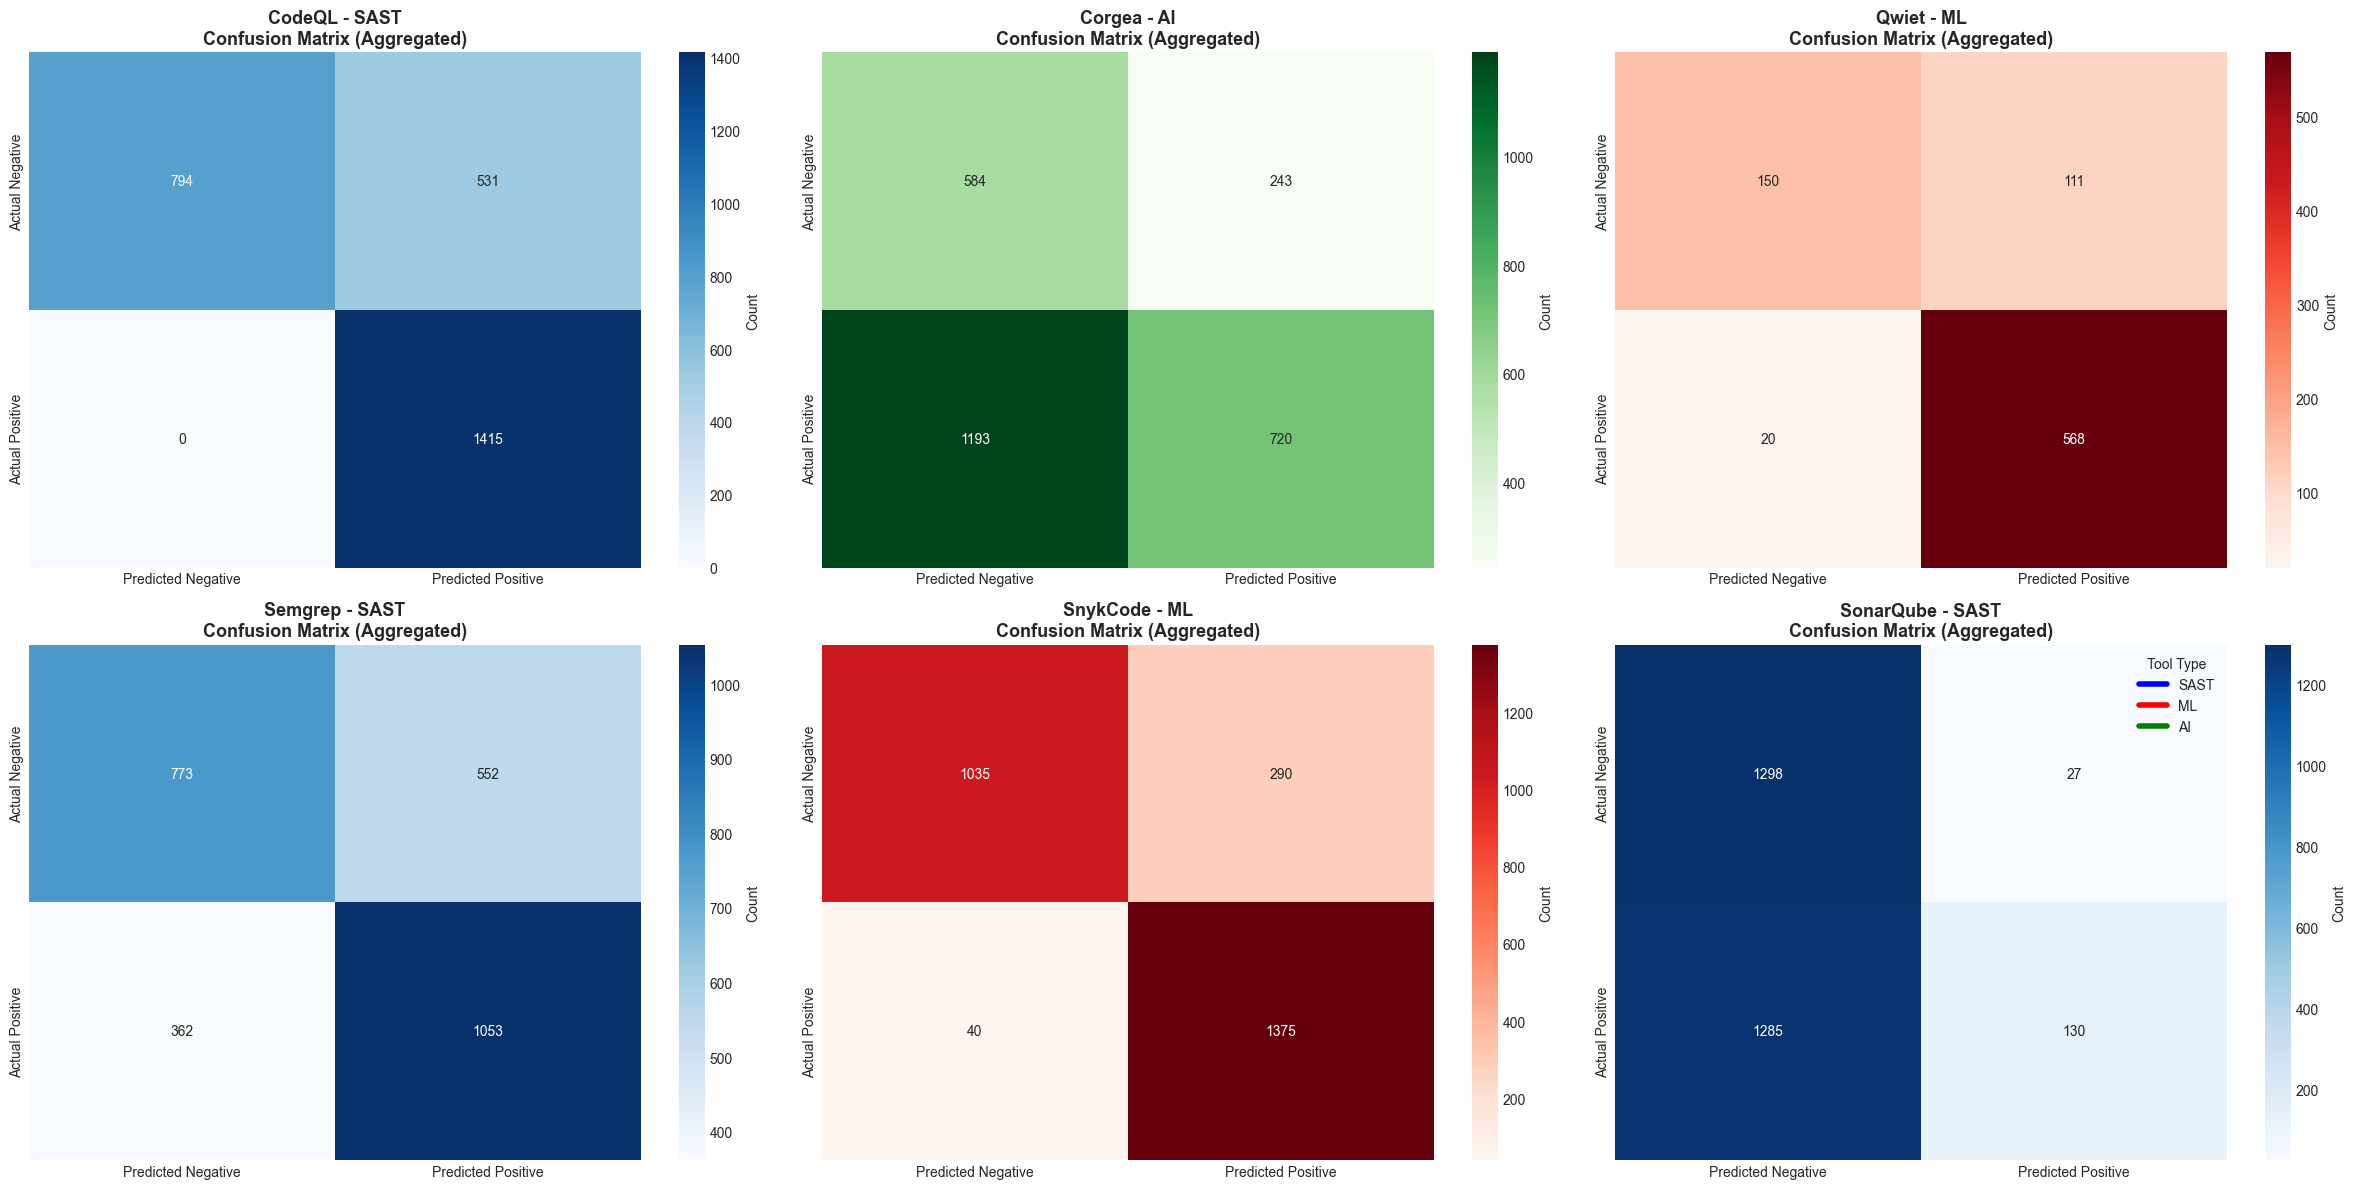

In [24]:
# aggregate confusion matrix values by tool
confusion_agg = df_tools.groupby('Tool')[['TP', 'FP', 'TN', 'FN']].sum()

fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

tools = confusion_agg.index

for idx, tool in enumerate(tools):
    if idx < 6:
        type = df_tools['Type'].loc[df_tools['Tool']==tool].unique()[0]
        values = confusion_agg.loc[tool]
        
        cm = np.array([[values['TN'], values['FP']],
                        [values['FN'], values['TP']]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap=type_to_cmap[type], ax=axes[idx],
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'],
                    cbar_kws={'label': 'Count'})
        
        axes[idx].set_title(f'{tool} - {type}\nConfusion Matrix (Aggregated)', 
                            fontsize=13, fontweight='bold')

# hide unused subplots if less than 4 tools
for idx in range(len(tools), 4):
    axes[idx].set_visible(False)

plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='SAST'),
    plt.Line2D([0], [0], color='red', lw=4, label='ML'),
    plt.Line2D([0], [0], color='green', lw=4, label='AI')
], title='Tool Type', loc='upper right')

plt.tight_layout()
plt.show()

## Export Summary

In [25]:
# if 'df_tools' in locals():
#     # export complete dataset
#     df_tools.to_csv(os.path.join(to_save,'summary.csv'), index=False)
    
#     # Export pivot tables
#     pivot_tpr.to_csv(os.path.join(to_save,'tpr_by_tool_and_vulnerability.csv'))
#     pivot_fpr.to_csv(os.path.join(to_save,'fpr_by_tool_and_vulnerability.csv'))
#     pivot_score.to_csv(os.path.join(to_save,'score_by_tool_and_vulnerability.csv'))
    
#     # Export summary statistics
#     summary_stats.to_csv(os.path.join(to_save,'summary_statistics.csv'))
    
#     if 'df_summary' in locals() and df_summary is not None:
#         df_summary.to_csv(os.path.join(to_save,'overall_tool_scores.csv'), index=False)